**Imports**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import saraRC1 as sara

In [2]:
def plot_heatmap(im, grid_size, name=None):
    '''
    Given an image im, this function plots the heatmap generated by SaRa for the given grid size.
    '''

    heatmap, _ = sara.return_sara(cv2.imread(im), grid_size)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    plt.rcParams['figure.figsize'] = [12, 6]
    plt.figure(name + ' SaRa Output - Grid Size ' +
               str(grid_size) + ' x ' + str(grid_size))
    plt.gcf().set_size_inches(12, 6)
    plt.imshow(heatmap)
    plt.xticks([])
    plt.yticks([])
    plt.title('SaRa Output - Grid Size ' +
              str(grid_size) + ' x ' + str(grid_size))


In [3]:
def plot_score_vs_grid_size(scores, name=None, do='score'):
    '''
    Given a dictionary of scores, this function plots the average score vs grid size.
    '''

    plt.figure(name + ' Average Score vs Grid Size (Logarithmic Scale)')
    for seg_dim in scores.keys():
        plt.plot(seg_dim, scores[seg_dim][1], 'bo')
        if seg_dim > 5:
            plt.plot([seg_dim - 1, seg_dim], [scores[seg_dim - 1][1], scores[seg_dim][1]], 'k-')
        plt.grid(True)

    plt.xlabel('Grid Size')
    plt.ylabel('Average Score (Top 25% Segments)')
    plt.title('Average Score vs Grid Size (Logarithmic Scale)')
    plt.yscale('log')

    plt.gcf().set_size_inches(12, 6)
    plt.show()


In [4]:
def display_top_4_grids(scores, name):
    '''
    Given a dictionary of scores, this function plots the top 4 grids which maximise average score.
    '''

    plt.figure(name + ' SaRa Output - Top 4 Grid Sizes')
    plt.gcf().set_size_inches(12, 6)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        im = cv2.imread(scores[i][1][3])
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(scores[i][1][0]) +
                  ' x ' + str(scores[i][1][0]))
    

**Experiment 1** – Average Entropy Maximisation

In [5]:
def maximise_entropy(im, name, n):
    '''
    Given an image im, this function returns the grid size that maximises the average score of the top n segments generated by SaRa.
    '''

    scores = {}
    s1 = cv2.imread(im)

    # All grid sizes
    plt.figure(name + ' SaRa Output - All Grid Sizes')
    plt.gcf().set_size_inches(12, 6)

    for seg_dim in range(5, n):
        heatmap, sara_list = sara.return_sara(s1.copy(), seg_dim)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Plot heatmap of grid size i x i
        plt.subplot(4, 5, seg_dim - 4)
        plt.imshow(heatmap)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(seg_dim) + ' x ' + str(seg_dim))

        # Output heatmap to file
        path = './output/' + name + \
            ' (' + str(seg_dim) + 'x' + str(seg_dim) + ').png'
        # heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
        # cv2.imwrite(path, heatmap)
        # print(f'Image saved to {path}')

        # Average entropy of the top 25% grid segments
        top = seg_dim * seg_dim // 4
        average = sum(sara_list[0:top][2]) / len(sara_list[0:top][2])
        scores[seg_dim] = (seg_dim, average, sara_list, path)

        sara.reset()

    scores_sorted = scores.copy()
    scores_sorted = sorted(scores_sorted.items(),
                              key=lambda x: x[1][1], reverse=True)

    return scores, scores_sorted


In [78]:
n = 25

path = '../images/'
name_a = 'groupatestmobile.png'
name_b = 'groupbtestmobile.png'

im_a = path + name_a
img_a = cv2.imread(im_a)
img_a_original = img_a.copy()
img_a = cv2.resize(img_a, (0, 0), fx=0.5, fy=0.5)

im_b = path + name_b
img_b = cv2.imread(im_b)
img_b_original = img_b.copy()
img_b = cv2.resize(img_b, (0, 0), fx=0.5, fy=0.5)

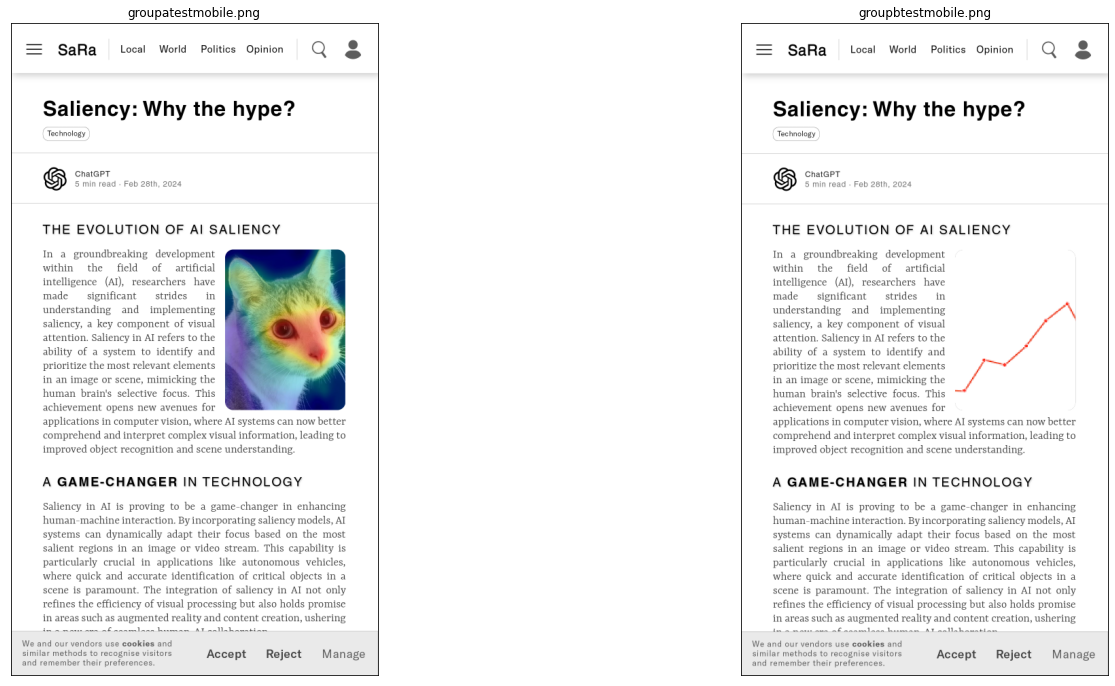

In [79]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB))
plt.title(name_a)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB))
plt.title(name_b)
plt.xticks([])
plt.yticks([])

plt.show()

In [80]:
saliency_map_a = sara.return_saliency(img_a, generator='deepgaze')
saliency_map_b = sara.return_saliency(img_b, generator='deepgaze')

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0


Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0


In [261]:
saliency_map_wilson = sara.return_saliency(img_wilson, generator='deepgaze')

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0


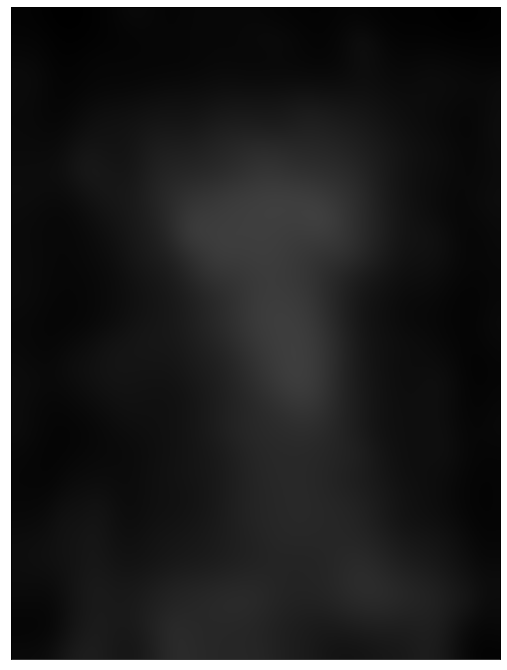

In [262]:
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(saliency_map_wilson, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

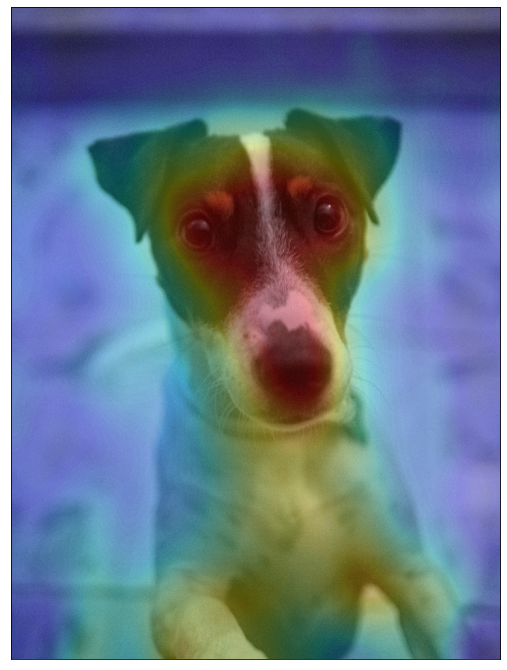

In [275]:
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(img_wilson, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])

plt.imshow(saliency_map_wilson, alpha=0.3, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.show()


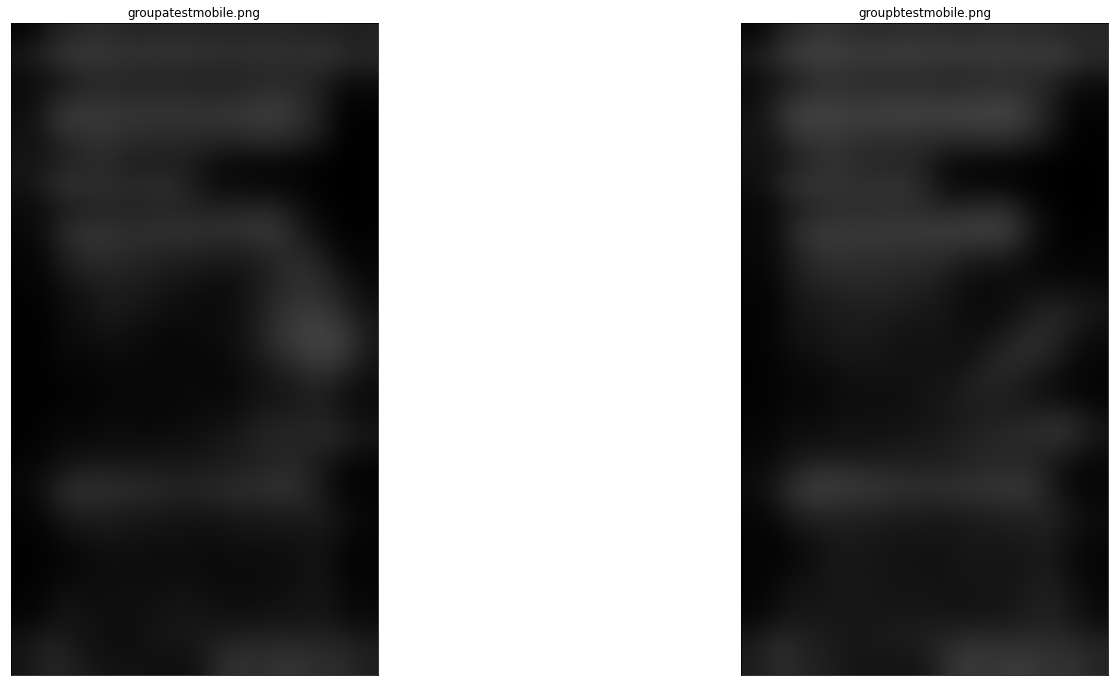

In [81]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(cv2.cvtColor(saliency_map_a, cv2.COLOR_BGR2RGB))
plt.title(name_a)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(saliency_map_b, cv2.COLOR_BGR2RGB))
plt.title(name_b)
plt.xticks([])
plt.yticks([])

plt.show()

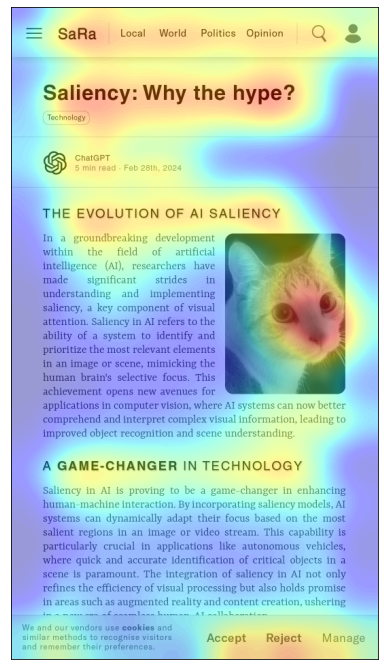

In [98]:
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.imshow(saliency_map_a, alpha=0.4, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.show()

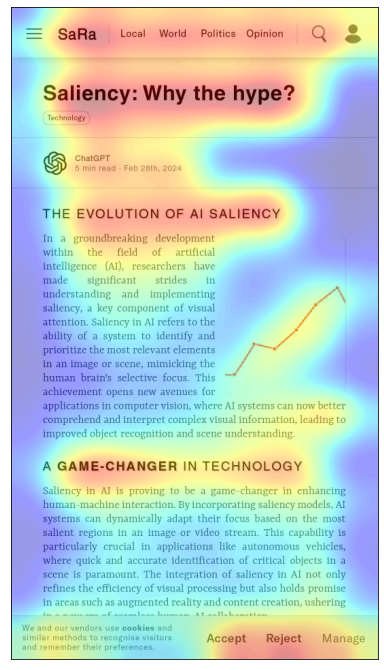

In [83]:
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB))
plt.imshow(saliency_map_b, alpha=0.4, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.show()

In [90]:
GRID_SIZE = 16
sara.WEIGHTS = (1, 1, 1, 1)
im_bigger_a = img_a.copy()
sara_heatmap_a, sara_list_a = sara.return_sara(img_a.copy(), GRID_SIZE, saliency_map=saliency_map_a)
sara_heatmap_a = cv2.cvtColor(sara_heatmap_a, cv2.COLOR_BGR2RGB)
sara.reset()

In [91]:
GRID_SIZE = 16
sara.WEIGHTS = (1, 1, 1, 1)
im_bigger_b = img_b.copy()
sara_heatmap_b, sara_list_b = sara.return_sara(img_b.copy(), GRID_SIZE, saliency_map=saliency_map_b)
sara_heatmap_b = cv2.cvtColor(sara_heatmap_b, cv2.COLOR_BGR2RGB)
sara.reset()

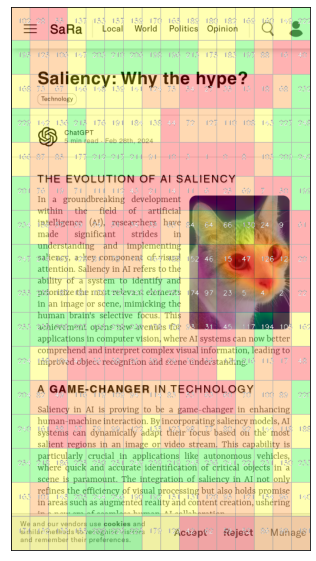

In [92]:
plt.figure(figsize=(10, 10))
plt.imshow(sara_heatmap_a)
plt.xticks([]), plt.yticks([])
plt.show()

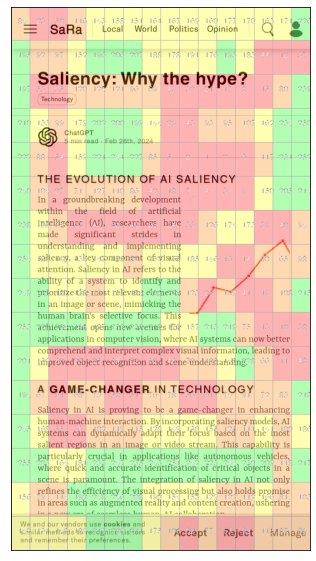

In [93]:
plt.figure(figsize=(10, 10))
plt.imshow(sara_heatmap_b)
plt.xticks([]), plt.yticks([])
plt.show()

In [53]:
[i[0] for i in sara_list_b]

[34,
 19,
 46,
 43,
 52,
 37,
 25,
 28,
 55,
 61,
 31,
 10,
 22,
 58,
 63,
 71,
 40,
 59,
 20,
 72,
 67,
 78,
 56,
 32,
 64,
 49,
 70,
 6,
 57,
 38,
 9,
 11,
 16,
 68,
 80,
 41,
 12,
 8,
 18,
 69,
 0,
 50,
 23,
 24,
 60,
 1,
 17,
 62,
 66,
 29,
 15,
 33,
 48,
 54,
 74,
 42,
 39,
 4,
 3,
 75,
 5,
 30,
 14,
 13,
 26,
 47,
 73,
 79,
 51,
 21,
 2,
 76,
 65,
 77,
 7,
 27,
 35,
 53,
 44,
 36,
 45]

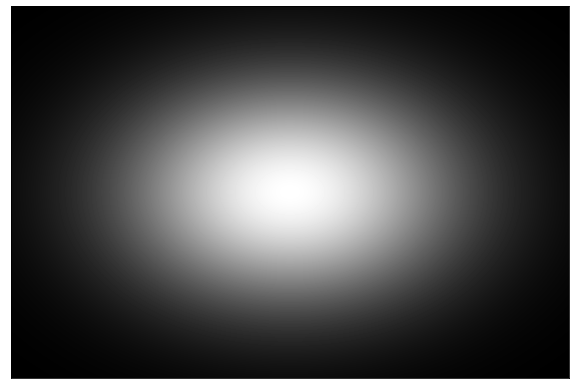

In [54]:
# Create a 512x512 image of agaussian kernel
kernel = cv2.getGaussianKernel(512, 106)
kernel = kernel * kernel.T
# Stretch to 1024 x 512
kernel = cv2.resize(kernel, (0, 0), fx=1.5, fy=1)

plt.figure(figsize=(10, 10))
plt.imshow(kernel, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [289]:
def index_to_coordinates(index, seg_dim, im_size):
    '''
    Given an index and a shape, this function returns the corresponding coordinates.
    '''

    x1 = int((index % seg_dim) * (im_size[1] / seg_dim))
    y1 = int((index // seg_dim) * (im_size[0] / seg_dim))

    x2 = int(x1 + (im_size[1] / seg_dim))
    y2 = int(y1 + (im_size[0] / seg_dim))
    
    return (x1, y1, x2, y2)

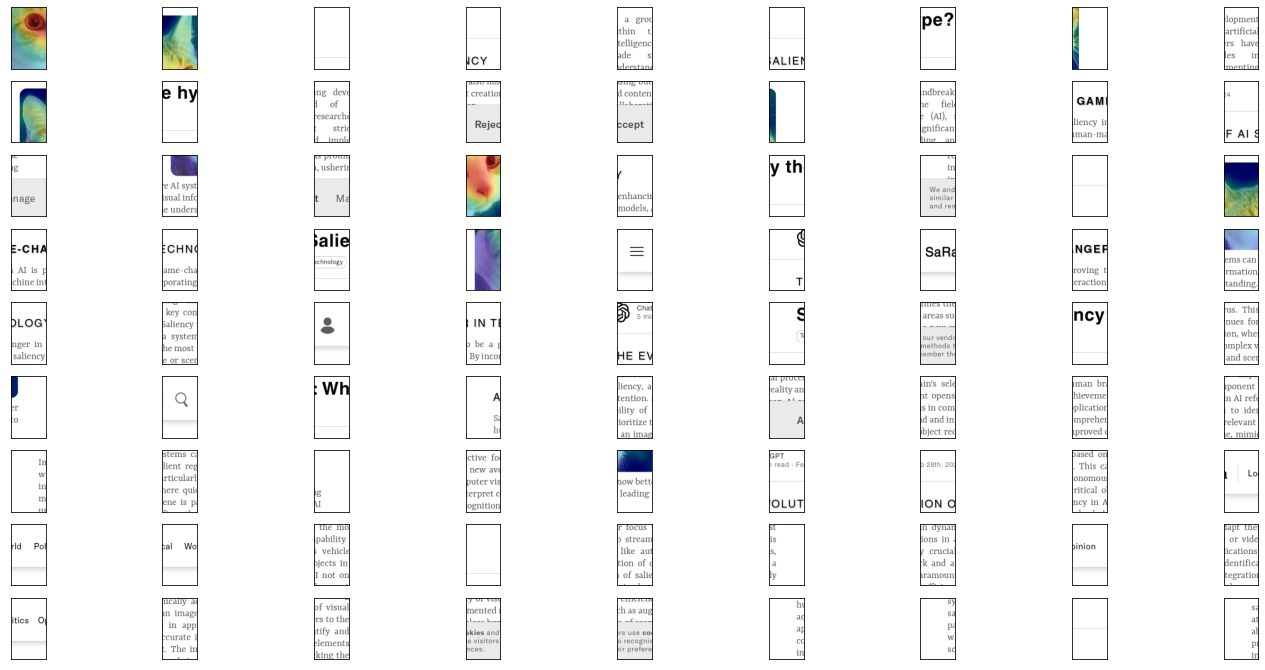

In [290]:
sara_list_sorted = sorted(sara_list_a, key=lambda x: x[1])

image_segments = []

for segment in sara_list_sorted:
    image_crop = img_a.copy()
    coordinates = index_to_coordinates(segment[0], GRID_SIZE, img_a.shape)
    image_crop = image_crop[coordinates[1]:coordinates[3], coordinates[0]:coordinates[2]]

    image_segments.append(image_crop)

plt.figure(figsize=(24, 12))
for i in range(GRID_SIZE * GRID_SIZE):
    plt.subplot(GRID_SIZE, GRID_SIZE, i + 1)
    plt.imshow(cv2.cvtColor(image_segments[i], cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])

plt.show()


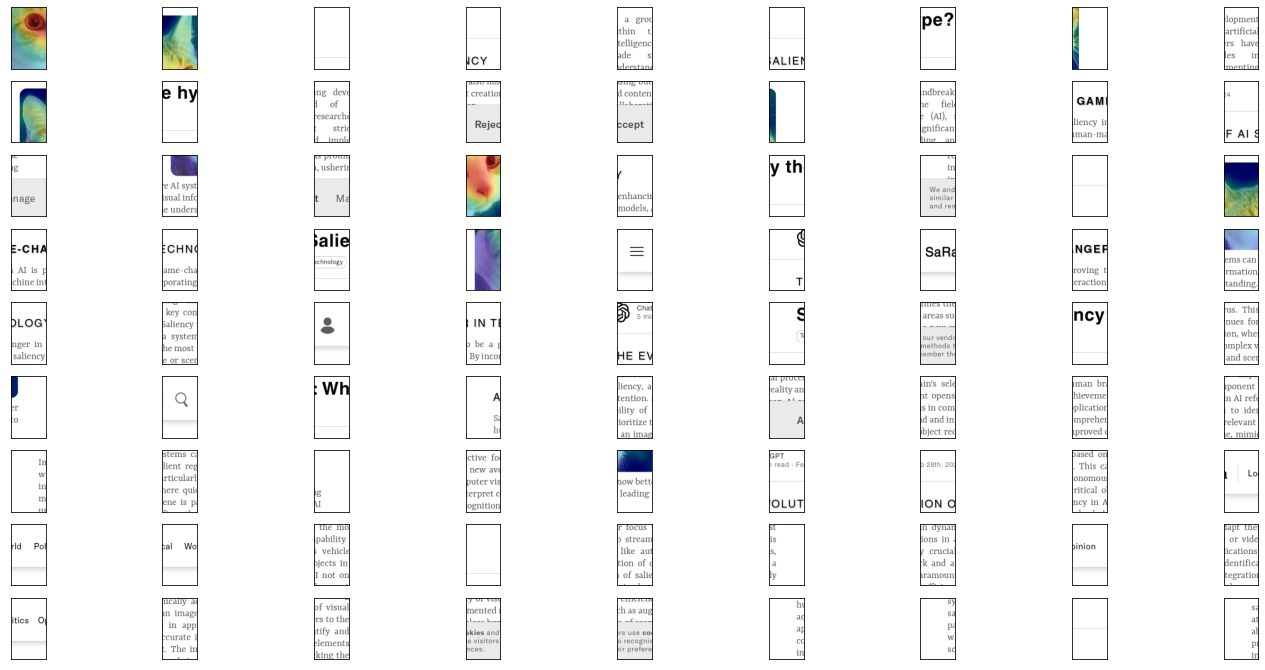

In [291]:
sara_list_sorted = sorted(sara_list_b, key=lambda x: x[1])

image_segments = []

for segment in sara_list_sorted:
    image_crop = img_b.copy()
    coordinates = index_to_coordinates(segment[0], GRID_SIZE, img_a.shape)
    image_crop = image_crop[coordinates[1]:coordinates[3], coordinates[0]:coordinates[2]]

    image_segments.append(image_crop)

plt.figure(figsize=(24, 12))
for i in range(GRID_SIZE * GRID_SIZE):
    plt.subplot(GRID_SIZE, GRID_SIZE, i + 1)
    plt.imshow(cv2.cvtColor(image_segments[i], cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])

plt.show()


In [46]:
sara_list_sorted = sorted(sara_list, key=lambda x: x[1])

image_segments = []

for segment in sara_list_sorted:
    image_crop = img_b.copy()
    coordinates = index_to_coordinates(segment[0], GRID_SIZE, img_a.shape)
    image_crop = image_crop[coordinates[1]:coordinates[3], coordinates[0]:coordinates[2]]

    image_segments.append(image_crop)

plt.figure(figsize=(24, 12))
for i in range(GRID_SIZE * GRID_SIZE):
    plt.subplot(GRID_SIZE, GRID_SIZE, i + 1)
    plt.imshow(cv2.cvtColor(image_segments[i], cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])

plt.show()


NameError: name 'sara_list' is not defined

In [292]:
for i, j in zip(sara_list_a, sara_list_b):
    print(i[0], j[0], i[0] - j[0])

42 42 0
34 34 0
16 16 0
24 24 0
28 28 0
23 23 0
15 15 0
44 44 0
31 31 0
32 32 0
14 14 0
30 30 0
78 78 0
77 77 0
35 35 0
29 29 0
55 55 0
22 22 0
80 80 0
50 50 0
79 79 0
43 43 0
61 61 0
13 13 0
72 72 0
25 25 0
33 33 0
56 56 0
59 59 0
10 10 0
41 41 0
0 0 0
18 18 0
1 1 0
57 57 0
51 51 0
60 60 0
38 38 0
8 8 0
58 58 0
19 19 0
9 9 0
73 73 0
11 11 0
49 49 0
53 53 0
7 7 0
12 12 0
54 54 0
37 37 0
76 76 0
47 47 0
46 46 0
39 39 0
27 27 0
64 64 0
62 62 0
48 48 0
52 52 0
20 20 0
21 21 0
69 69 0
2 2 0
4 4 0
3 3 0
70 70 0
17 17 0
68 68 0
71 71 0
65 65 0
6 6 0
67 67 0
5 5 0
66 66 0
40 40 0
75 75 0
74 74 0
45 45 0
63 63 0
26 26 0
36 36 0


array([[ 7,  7,  7, ..., 33, 33, 33],
       [ 7,  7,  7, ..., 33, 33, 33],
       [ 7,  7,  7, ..., 33, 34, 34],
       ...,
       [21, 21, 21, ..., 31, 31, 31],
       [21, 21, 21, ..., 31, 31, 31],
       [21, 21, 21, ..., 31, 31, 31]], dtype=uint8)

c:\Users\matth\anaconda3\envs\coco\lib\site-packages\ipykernel_launcher.py:48: UserWarning: set_ticks() must have been called.


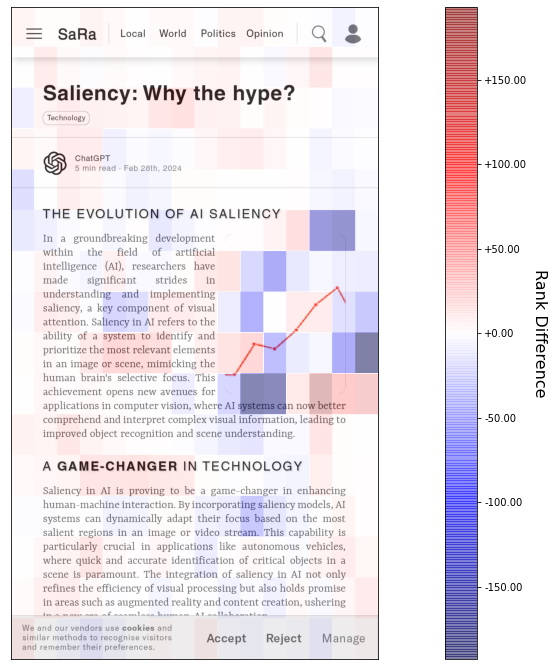

In [94]:
from matplotlib.colors import LinearSegmentedColormap

# Calculate the difference in ranks between sara_list_a and sara_list_b, create a heatmap of the differences - each list is sorted by rank, index 0 = index in grid, index 1 = rank
diff = np.zeros((GRID_SIZE, GRID_SIZE))

sara_list_a_sorted = sorted(sara_list_a, key=lambda x: x[0])
sara_list_b_sorted = sorted(sara_list_b, key=lambda x: x[0])

for i in range(GRID_SIZE * GRID_SIZE):
    diff[i // GRID_SIZE][i % GRID_SIZE] = sara_list_a_sorted[i][1] - sara_list_b_sorted[i][1]

ncolors = 256
color_array = plt.get_cmap('seismic')(np.linspace(0, 1, 256))


# Make it so color_array is transparent in the middle and opaque at the extremes
color_array[:,-1] = np.abs(np.linspace(-1, 0.6,ncolors))

# Make minimum transparency 0.5 unless exactly 0 (which should be fully transparent)
color_array[:,-1] = np.maximum(color_array[:,-1], 0.4)


map_object = LinearSegmentedColormap.from_list(name='coolwarm_alpha',colors=color_array)
plt.register_cmap(cmap=map_object)



# Show image B
plt.figure(figsize=(24, 12))
# plt.imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.imshow(cv2.cvtColor(img_b_original, cv2.COLOR_BGR2RGB))
# Expand diff to twice its size
diff = cv2.resize(diff, (img_a_original.shape[1], img_a_original.shape[0]), interpolation=cv2.INTER_NEAREST)
# plt.imshow(img_b, alpha=1, cmap='gray')
plt.xticks([]), plt.yticks([])

# Show heatmap overlayed on top of image B
# Show heatmap overlayed on top of image B using the "coolwarm" colormap, adjust to the range such that a difference of 0 is white, more white = more transparent
heatmap = plt.imshow(diff, cmap='coolwarm_alpha', alpha=0.5, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
plt.xticks([]), plt.yticks([])

# Add a colorbar to the right of the image
cbar = plt.colorbar(heatmap, format='%+.2f')  # Use the format parameter to control decimal places

# Modify colorbar labels to include a plus sign for positive values
tick_labels = cbar.get_ticks()
tick_labels_str = [f'{label:+.2f}' if label >= 0 else f'{label:.2f}' for label in tick_labels]
cbar.set_ticklabels(tick_labels_str)

# Add cbar title "Rank Difference"
cbar.set_label('Rank Difference', labelpad=20, rotation=270, fontsize=16)

plt.show()

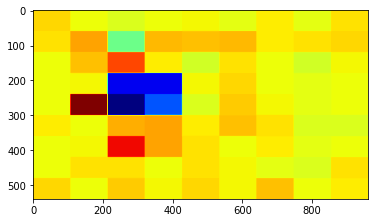

In [181]:
plt.imshow(diff, cmap='jet')